# Red neuronal aplicado a la relación Bitcoin con el S&P500

Continuando con este estudio aplicaremos una red neuronal para mostrar que el comportamiento de Bitcoin puede ser modelado usando como variables la el volumen de las transacciones de Bitcoin y el valor del S&P500.

Considero que la mejor forma de dividir los datos es usar el propio ciclo de Bitcoin por lo que se usaran los halvings de Bitcoin, siendo el primero (el primero luego del lanzamiento de Bitcoin) el día 9 de Julio del 2016 y el último el día 20 de Abril del 2024.

Usaremos un el modelo LSTM con dos capas, con 100 neuronas cada una, el optimizador Adam y el error cuadrático medio como función de pérdida.

La hipótesis que pretendemos consolidar es que en el modelo propuesto se puede sustituir un porcentaje del S&P500 por Bitcoin.

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
dataBIT = yf.download("BTC-USD", start = "2016-07-09", end = "2024-04-19")
df1 = dataBIT[[('Close', 'BTC-USD')]]
df1.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2016-07-09,650.960022
2016-07-10,649.359985
2016-07-11,647.658997
2016-07-12,664.551025
2016-07-13,654.468018


In [ ]:
dataSP = yf.download("^GSPC", start = "2016-07-09", end = "2024-04-19")
df2 = dataSP[('Close', '^GSPC')]
df2.head()

[*********************100%***********************]  1 of 1 completed


,Close
,^GSPC
Date,
2016-07-11,2137.159912
2016-07-12,2152.139893
2016-07-13,2152.429932
2016-07-14,2163.750000
2016-07-15,2161.739990


In [ ]:
train_data = pd.merge(df1, df2, how = 'inner', on = 'Date')
train_data.columns = ['SP500_Close', 'Bitcoin_Volume']
train_data.head()

,SP500_Close,Bitcoin_Volume
Date,,
2016-07-11,647.658997,2137.159912
2016-07-12,664.551025,2152.139893
2016-07-13,654.468018,2152.429932
2016-07-14,658.078003,2163.750000
2016-07-15,663.255005,2161.739990


In [ ]:
train_data.isna().sum()

,0
SP500_Close,0
Bitcoin_Volume,0


In [ ]:
train_data.describe()

,SP500_Close,Bitcoin_Volume
count,1957.000000,1957.000000
mean,19492.255938,3408.765233
std,17704.674789,841.855026
min,547.465027,2085.179932
25%,6378.849121,2705.570068
50%,10912.823242,3232.389893
75%,30111.998047,4167.589844
max,73083.500000,5254.350098


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 60)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(1897, 60, 2)
(1897,)


In [ ]:
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,701 (475.39 KB)

 Trainable params: 121,701 (475.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - loss: 0.1252
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0015
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0012
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0010
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0011
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0011
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 8.3278e-04
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 9.2512e-04
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 7.9467e-04
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.5216e-04
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 9.4707e-04
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - loss: 7.6527e-04
Epoch 13/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 6.9552e-04
Epoch 14/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 6.0520e-04
Epoch 15/50
60/60 ━━━━━━━━━━━━━━━━━━

In [ ]:
dataBIT_24_25 = yf.download("BTC-USD", start = "2024-04-20", end = "2025-04-10")
df3 = dataBIT_24_25[[('Close', 'BTC-USD')]]
dataSP_24_25 = yf.download("^GSPC", start = "2024-04-20", end = "2025-04-10")
df4 = dataSP_24_25[('Close', '^GSPC')]
real_data = pd.merge(df3, df4, how = 'inner', on = 'Date')
real_data.columns = ['SP500_Close', 'Bitcoin_Volume']
real_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SP500_Close,Bitcoin_Volume
Date,,
2024-04-22,66837.679688,5010.600098
2024-04-23,66407.273438,5070.549805
2024-04-24,64276.898438,5071.629883
2024-04-25,64481.707031,5048.419922
2024-04-26,63755.320312,5099.959961


In [ ]:
real_data.isna().sum()

,0
SP500_Close,0
Bitcoin_Volume,0


In [ ]:
real_scaled = scaler.transform(real_data)

X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 1))], axis=1))[:, 0]

valor_real = scaler.inverse_transform(real_scaled)[:, 0]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


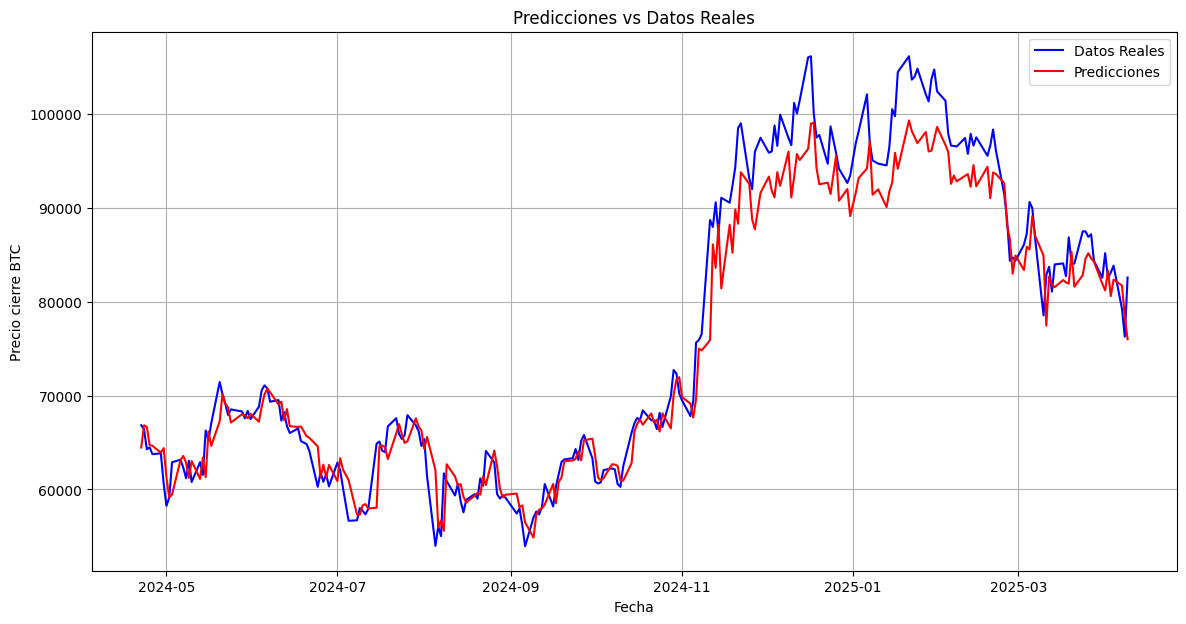

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(real_data.index, valor_real, label='Datos Reales', color='blue')
plt.plot(real_data.index[:len(predictions)], predictions, label='Predicciones', color='red')
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Precio cierre BTC')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import plotly.graph_objects as go

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
valor_real = pd.Series(valor_real[:len(predictions)], index=real_data.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in valor_real.groupby(valor_real.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared:.4f}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data.index, y=valor_real, mode='lines', name='Datos Reales', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales',
    xaxis_title='Fecha',
    yaxis_title='Estimación Valor de Cierre BTC',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

R-squared para el mes 1: -1.6181
R-squared para el mes 2: 0.5335
R-squared para el mes 3: -0.1233
R-squared para el mes 4: 0.9087
R-squared para el mes 5: 0.6851
R-squared para el mes 6: 0.7989
R-squared para el mes 7: 0.6670
R-squared para el mes 8: -0.1180
R-squared para el mes 9: 0.7798
R-squared para el mes 10: 0.8248
R-squared para el mes 11: 0.6621
R-squared para el mes 12: -1.2227


# Conclusión:

Considero que el modelo predice de manera bastante adecuada el comportamiento de Bitcoin. Si bien los valores de R-cuadrada son elevados una posible explicación es la gran volatilidad provocada por la gran incertidumbre debida a la política ecónomica del presidente D. Trump (tanto a la narrativa que manejo desde su campaña hasta la narrativa y acciones que ha venido implementando como presidente).

Es importante recalcal que el motivo de este análisis no es predecir el valor de Bitcoin, ya que incluso, aunque el modelo se ajustase a la perfección, este dependería de la predicción del comportamiento del S&P500 lo cual es imposible.

El principal objetivo de este análisis es verificar que el comportamiento de Bitcoin está fuertemente correlacionado, de manera directa, con el comportamiento del S&P500.

Otro punto a favor de este modelo es que el valor real está por encima del valor predecido. Esto es positivo en el contexto del modelo de inversión pasivo y a largo plazo que propone el modelo de Swensen.